# Exploring Web Map Service (WMS)  

1. <a href="#helperFunctions">Image Helper Funcitons</a>
2. <a href="#mainLibs">WMS and OWSLib</a>
3. <a href="#serviceInfo">Getting some information about the service</a>
4. <a href="#basicGetMap">Getting the basic information we need to perform a GetMap request</a>
5. <a href="#advancedGetMap">More on GetMap request</a>
6. <a href="#ncWmsExtensions">TDS-ncWMS styles and extensions</a>
7. <a href="#wmsAndCartopy">WMS and Cartopy</a>

# 1. <a name="helperFunctions">Image Helper Functions</a>
 * At a very basic level, a WMS service returns an image
 * Let's define a few helper functions to save and load images from a temporairy directory or url

In [1]:
# Function to get tmp image dir. If it does not exist, 
#  create it
def getTmpImgDir():
    from os import makedirs
    from os.path import exists, join
    tmp_img_dir = "tmp_img"
    if (not exists(tmp_img_dir)):
        makedirs(tmp_img_dir)
    return tmp_img_dir

#Function that saves the layer as an image
def saveLayerAsTmpImage(layer, inname):
    from os.path import join
    tmp_img_dir = getTmpImgDir()
    full_img_path = join(tmp_img_dir, inname)
    out = open(full_img_path, 'wb')
    out.write(layer.read())
    out.close()

# Function to load image
def loadTmpImage(image_name):
    from IPython.core.display import Image
    from os.path import join
    tmp_img_dir = getTmpImgDir()
    filename = join(tmp_img_dir, image_name)
    return Image(filename)

# Function to display image from a url
def loadRemoteImage(imgUrl):
    from IPython.core.display import Image
    return Image(url = imgUrl)

# 2. <a name="mainLibs">About WMS and OWSLib</a>
- WMS is the Open Geospatial Consortium (OGC) standard interface for requesting georeferenced __images__ through HTTP.
- OWSLib is part of [geopython](http://geopython.github.io/), a GitHub organization comprised of Python projects related to geospatial. 
- OWSLib is a Python package for client programming with OGC Web Services (OWS) developed by [Tom Kralidis](http://www.kralidis.ca/).
- OWSLib supports several OGC standards: WFS, WCS, SOS...and of course WMS 1.1.1. [More](http://geopython.github.io/OWSLib/).  

# 3. <a name="serviceInfo">Getting some information about the service</a>  
  
* We will use OWSLib package and in particular the owslib.wms module.
* Within the TDS context, if WMS is enabled and set up in the catalogs, each dataset in the catalog will have a WMS access url
* Let's use Siphon to get WMS access url for the latest run of the NCEP HRRR model.
    

In [2]:
from owslib.wms import WebMapService
from siphon.catalog import get_latest_access_url

# just need a WMS url from one TDS dataset...NCEP HRRR 2.5km forecast model
catalog = 'http://thredds-jumbo.unidata.ucar.edu/thredds/catalog/grib/NCEP/HRRR/CONUS_2p5km/catalog.xml'
serverurl = get_latest_access_url(catalog, 'WMS')

wms = WebMapService( serverurl, version='1.1.1')
wms.url

'http://thredds-jumbo.unidata.ucar.edu/thredds/wms/grib/NCEP/HRRR/CONUS_2p5km/HRRR_CONUS_2p5km_20150703_1600.grib2'

## The WebMapService object gets all the information available about the service through a GetCapabilities request:

In [3]:
#This is general information, common to all datasets in a TDS server
operations =[ op.name for op in  wms.operations ]
print('Available operations: ')
print(operations)

print('General information (common to all datasets):')
print(wms.identification.type)
print(wms.identification.abstract)
print(wms.identification.keywords)
print(wms.identification.version)
print(wms.identification.title)

Available operations: 
['GetCapabilities', 'GetMap', 'GetFeatureInfo']
General information (common to all datasets):
OGC:WMS
Scientific Data
['meteorology', 'atmosphere', 'climate', 'ocean', 'earth science']
1.1.1
THREDDS Data Server


## What's in the dataset?
- Each variable in a dataset translates into a layer in the WMS service. 
- Bounding boxes, styles and dimensions are specific to each layer. 
- The server creates virtual layers if it finds vector components in CF-1 or Grib conventions. 

In [4]:
#Listing all available layers...
layers = list(wms.contents)
for l in layers:
    print('Layer title: '+wms[l].title +', name:'+wms[l].name)

Layer title: Visibility @ Ground or water surface, name:Visibility_surface
Layer title: Total precipitation (1_Hour Accumulation) @ Ground or water surface, name:Total_precipitation_surface_1_Hour_Accumulation
Layer title: Convective inhibition @ Level at specified pressure difference from ground to level layer, name:Convective_inhibition_pressure_difference_layer
Layer title: v-component of wind @ Isobaric surface, name:v-component_of_wind_isobaric
Layer title: High cloud cover @ High cloud layer, name:High_cloud_cover_high_cloud
Layer title: u-component of wind @ Specified height level above ground, name:u-component_of_wind_height_above_ground
Layer title: Convective inhibition @ Ground or water surface, name:Convective_inhibition_surface
Layer title: Wind speed (1_Hour Maximum) @ Specified height level above ground, name:Wind_speed_height_above_ground_1_Hour_Maximum
Layer title: Hourly Maximum of Simulated Reflectivity at 1 km AGL (1_Hour Maximum) @ Specified height level above grou

# 4. <a name="basicGetMap">Getting the basic information we need to perform a GetMap request</a>

-  All the information that clients need is available in the capabilities document, which is stored in the WebMapService object.
-  The WMS included in the TDS (ncWMS) only supports GetMap requests on one layer (variable).
-  We need to choose our layer, bounding box, spatial reference system (SRS), the size, and format of the image.

## What is available?


In [5]:
#Values common to all GetMap requests: formats and http methods:
print(wms.getOperationByName('GetMap').formatOptions)
print(wms.getOperationByName('GetMap').methods)

#Let's choose: 'wind @ Isobaric surface' (the value in the parameter must be name of the layer)
wind = wms['wind @ Isobaric surface']

#What is its bounding box?
print(wind.boundingBox)

#available CRS
print(wind.crsOptions)
# --> NOT ALL THE AVAILABLE CRS OPTIONS ARE LISTED
# print elevations at which the wind is avaliable
elevations = [elevation.strip() for elevation in wind.elevations]
print(elevations)
# units on the elevation are not exposed. 50,000 for a height -> probably Pa

['image/png', 'image/png;mode=32bit', 'image/gif', 'image/jpeg', 'application/vnd.google-earth.kmz']
[{'type': 'Get', 'url': 'http://thredds-jumbo.unidata.ucar.edu/thredds/wms/grib/NCEP/HRRR/CONUS_2p5km/HRRR_CONUS_2p5km_20150703_1600.grib2'}]
(-130.12289354741372, 20.17862215527375, -60.86645064452432, 50.11284676676232, 'EPSG:4326')
['CRS:84', 'EPSG:41001', 'EPSG:27700', 'EPSG:4326', 'EPSG:3408', 'EPSG:3857', 'EPSG:3409', 'EPSG:32661', 'EPSG:32761']
['50000.0', '70000.0', '85000.0', '92500.0', '100000.0']


## Ok, let's request an image from the layer!

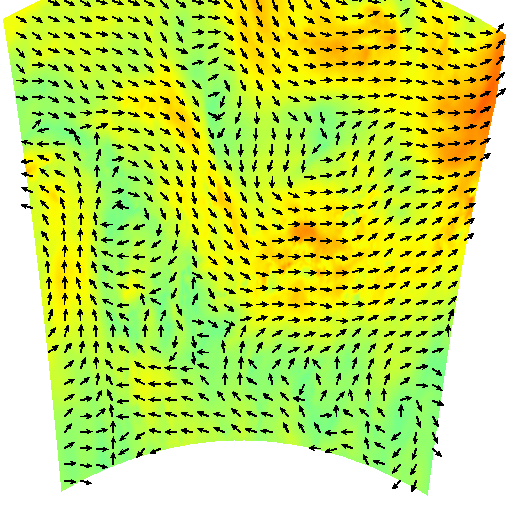

In [6]:
img_wind = wms.getmap( layers=[wind.name], #only takes one layer
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(512, 512),
                  format='image/png',
                  elevation=elevations[0])

# Save it..
saveLayerAsTmpImage(img_wind, 'test_wind.png')

# Display the image we've just saved...
loadTmpImage('test_wind.png')

# 5. <a name="advancedGetMap">More on GetMap requests</a>

* Handling time and vertical dimensions
* Changing styles
* Changing the spatial reference system (SRS)


## Handling time and vertical dimensions
* Getting available times and elevations for a layer
* We can choose any of the available times and make a request for it with the parameter time
* If no time is provided the default in TDS is the closest available time to the current time

In [7]:

times = [time.strip() for time in wind.timepositions]
print(times)
elevations = [elevation.strip() for elevation in wind.elevations]
print("")
print(elevations)

['2015-07-03T16:00:00.000Z', '2015-07-03T17:00:00.000Z', '2015-07-03T18:00:00.000Z', '2015-07-03T19:00:00.000Z', '2015-07-03T20:00:00.000Z', '2015-07-03T21:00:00.000Z', '2015-07-03T22:00:00.000Z', '2015-07-03T23:00:00.000Z', '2015-07-04T00:00:00.000Z', '2015-07-04T01:00:00.000Z', '2015-07-04T02:00:00.000Z', '2015-07-04T03:00:00.000Z', '2015-07-04T04:00:00.000Z', '2015-07-04T05:00:00.000Z', '2015-07-04T06:00:00.000Z', '2015-07-04T07:00:00.000Z']

['50000.0', '70000.0', '85000.0', '92500.0', '100000.0']


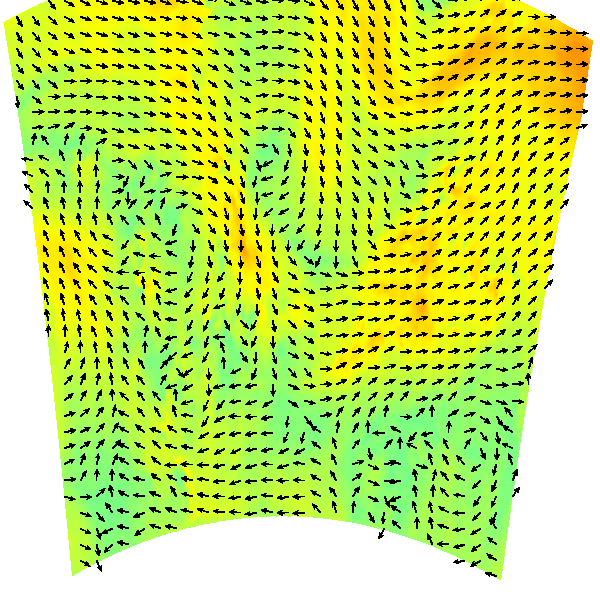

In [8]:
img_wind = wms.getmap( layers=[wind.name], 
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  elevation=elevations[0],
                  time= times[-1]
)

saveLayerAsTmpImage(img_wind, 'test_wind.png')
loadTmpImage('test_wind.png')

## Animations
* We can also specify a time interval to get an animated gif
* Format must be image/gif

In [9]:
img_wind = wms.getmap( layers=[wind.name], 
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/gif',
                  elevation=elevations[0],
                  time= "{}/{}".format(times[0],times[4])
)

from IPython.core.display import Image
loadRemoteImage(img_wind.geturl())

* Getting the available vertical levels:  
OWSLib does not support vertical levels, meaning the layer objects do not have a property "elevations" with the vertical levels. So, we need a little extra work to get the available vertical levels for a layer

### Changing styles
* We can specify the style (any from the available styles for a layer) in the param styles

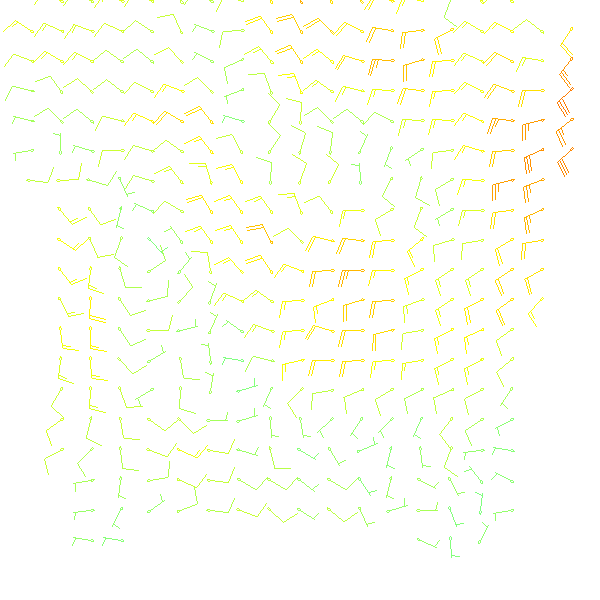

In [10]:
#available styles: 
#print wind.styles
#Change the style of our layer
img_wind = wms.getmap( layers=[wind.name], #only takes one layer
                  styles=['barb/rainbow'], #one style per layer    
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  elevation=elevations[0],
                  time= times[0]
)

saveLayerAsTmpImage(img_wind, 'test_wind_barb.png')
loadTmpImage('test_wind_barb.png')

### Changing the spatial reference system (SRS)
* We can reproject to any of the available SRS.

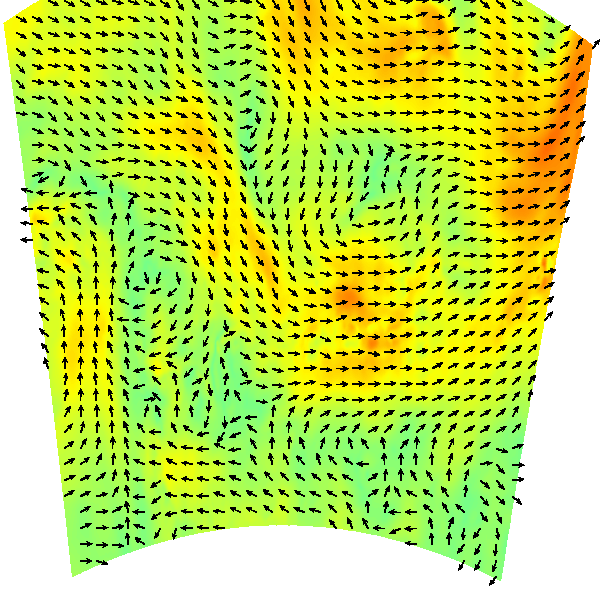

In [11]:
#Reproject the bounding box to a global mercator (EPSG:3875, projection used by Google Maps, OSM...) using cartopy
import cartopy.crs as ccrs
epsg = 3857
psproj = ccrs.epsg(epsg)
xmin, ymin = psproj.transform_point(wind.boundingBox[0], wind.boundingBox[1], ccrs.Geodetic())
xmax, ymax = psproj.transform_point(wind.boundingBox[2], wind.boundingBox[3], ccrs.Geodetic())
img_wind = wms.getmap( layers=[wind.name],
                  srs='EPSG:%d' % epsg,
                  bbox=(xmin, ymin, xmax, ymax),
                  size=(600, 600),
                  format='image/png',
                  elevation=elevations[0],
                  time= times[0]
)

saveLayerAsTmpImage(img_wind, 'test_wind_3857.png')
loadTmpImage('test_wind_3857.png')

## Finally, let's see how much work it is to change our layer

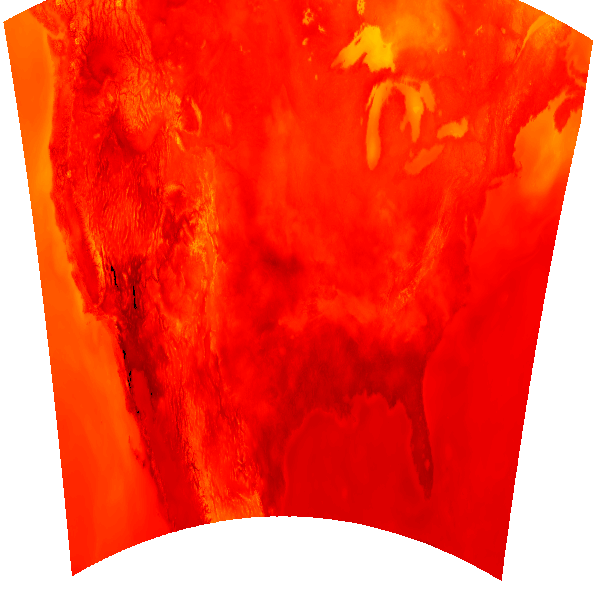

In [12]:
temp = wms['Temperature_height_above_ground']
img_temp = wms.getmap( layers=[temp.name], 
                  styles=['boxfill/rainbow'], 
                  srs='EPSG:4326',
                  bbox=(temp.boundingBox[0],temp.boundingBox[1], temp.boundingBox[2], temp.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  elevation=2,
                  time= times[0]
)

saveLayerAsTmpImage(img_temp, 'test_temp.png')
loadTmpImage('test_temp.png')

# 6. <a name="ncWmsExtensions">TDS-ncWMS styles and extensions<a/>

* ncWMS/THREDDS provides some __[non-standard WMS parameters](http://www.resc.rdg.ac.uk/trac/ncWMS/wiki/WmsExtensions)__ that allow clients some control on the styling.

* Change the scale range: 
 * Default is -50,50. Parameter colorscalerange allows us to use a different scale  


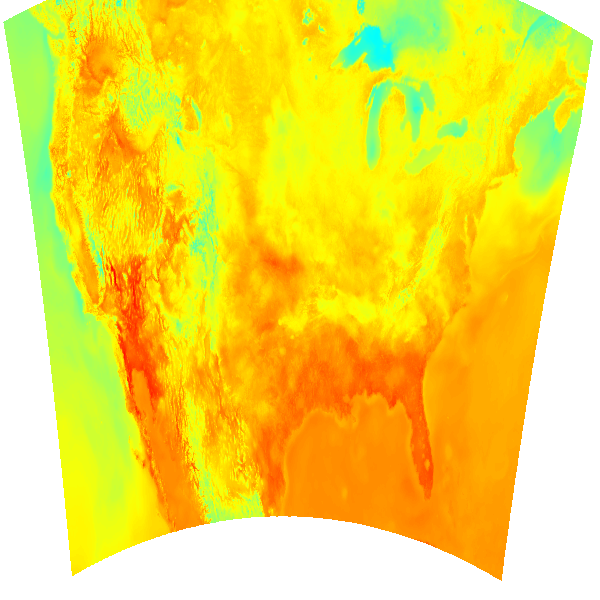

In [13]:
img_temp = wms.getmap( layers=[temp.name], 
                  styles=['boxfill/rainbow'], 
                  srs='EPSG:4326',
                  bbox=(temp.boundingBox[0],temp.boundingBox[1], temp.boundingBox[2], temp.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  time= times[0],
                  colorscalerange='250,320'
)

saveLayerAsTmpImage(img_temp, 'test_temp.png')
loadTmpImage('test_temp.png')

# More control over colors
* abovemaxcolor, belowmincolor params give us control on how we want the values out of range to be displayed.
* valid values for those params are: extend (will use the highest/lowest value of the palette for values larger/smaller than the maximun/minimun), transparent and a color in 0xRRGGBB format
* sytles: defines the colorbar used

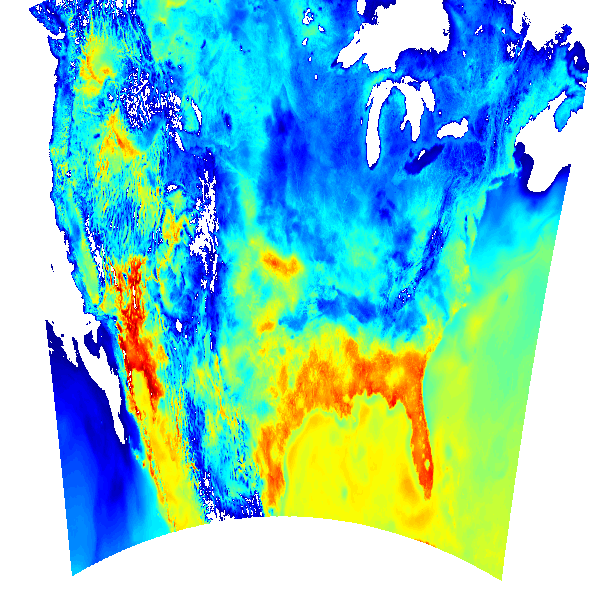

In [14]:
colorscalerange='290,310'

img_temp = wms.getmap( layers=[temp.name], 
                  styles=['boxfill/rainbow'], 
                  srs='EPSG:4326',
                  bbox=(temp.boundingBox[0],temp.boundingBox[1], temp.boundingBox[2], temp.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  time= times[0],
                  colorscalerange=colorscalerange,
                  abovemaxcolor='transparent',
                  belowmincolor='transparent'
)
saveLayerAsTmpImage(img_temp, 'test_temp.png')
loadTmpImage('test_temp.png')

## The GetLegendGraphic request gives us a legend for the map, but the request is not supported by OWSLib.

In [15]:
params ={'request': 'GetLegendGraphic',
         'colorbaronly':'False', #want the text in the legend
         'layer':temp.name,
         'colorscalerange':colorscalerange}

legendUrl=serverurl+'?REQUEST={request:s}&COLORBARONLY={colorbaronly:s}&LAYER={layer:s}&COLORSCALERANGE={colorscalerange:s}'.format(**params)

loadRemoteImage(legendUrl)


## 7. <a name="wmsAndCartopy">ncWMS and Cartopy</a>  
 * We can use Cartopy geolocate a layer and overlay it with political borders and coastlines
 * Note that Cartopy directly use the return from the WMS service, so no need to use the helper functions to save an image to a temporary location
 * Cartopy is ***not*** limited to using the colorbars from ncWMS.
 * Cartopy is ***not*** limited to using the projections enabled by ncWMS.

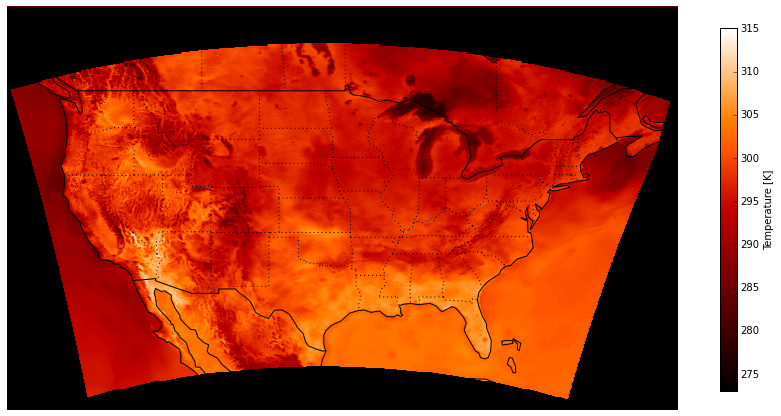

In [16]:
%matplotlib inline
import cartopy
import matplotlib as mpl
import matplotlib.pyplot as plt

# get the first time - Forecast Hour 0
times = [time.strip() for time in temp.timepositions]
time = times[0]
# only one elevation, so use it
elevations = [elevation.strip() for elevation in temp.elevations]
elevation = elevations[0]
# have to guess the range
color_max = 315  # K
color_min = 273  # K
colorscalerange = '{},{}'.format(color_min,color_max)

# pick a projection - going with Miller for this example
# note that with Cartopy you are NOT limited to the projections avaliable through ncWMS
plt_proj = cartopy.crs.Miller()

fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection': plt_proj})

# Colorbar goodness
cax = fig.add_axes([0.95, 0.3, 0.02, 0.42])
norm = plt.Normalize(vmin=color_min, vmax=color_max)
cmap = plt.cm.gist_heat
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, spacing='proportional', orientation='vertical')
cb.set_label('Temperature [K]')

# use bounding box info obtained from the ncWMS service to frame the image
extent = (temp.boundingBox[0], temp.boundingBox[2], temp.boundingBox[1], temp.boundingBox[3])
ax.set_extent(extent)

# ncWMS keywords (which includes the WMS keywords as well)
wms_kwargs = {'colorscalerange': colorscalerange,
              'abovemaxcolor': 'transparent',
              'belowmincolor': 'transparent',
              'transparent': 'true',
              'elevation': elevation,
              'time': time}

# plot the layer using Cartopy's WMS interface
ax.add_wms(wms=serverurl, layers=[temp.name], wms_kwargs=wms_kwargs, cmap=cmap)

# add coastlines, country borders and state outlines
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none'), linestyle=':')

##Exercise:
- Get the vertical levels for the layer temp.
- Change the request for getting the highest level.
- Change the color scale range to appropriate values.